### ДЗ 2. Для начала проделаем все те шаги, которые мы сделали на уроке, а потом уже перейдем к расчету эмбедингов#

### Переходим к практике

In [1]:
#!pip install razdel

In [2]:
#!pip install pymorphy2

In [3]:
#!pip install pyLDAvis

Делаем доступ к Googl Drive

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')

Наши новости

In [5]:
#from google.colab import files

#uploaded = files.upload()



In [6]:
import pandas as pd

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [7]:
news = pd.read_csv("../lesson_2/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [8]:
news.shape

(27000, 2)

Загрузим пользователей и списки последних прочитанных новостей

In [9]:
users = pd.read_csv("../lesson_2/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [10]:
#!pip install gensim

In [11]:
from gensim.test.utils import common_texts
# https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/
from gensim.corpora.dictionary import Dictionary

c:\users\anatoly\appdata\local\programs\python\python39\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anatoly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer(  )

In [15]:
len(stopword_ru)

151

In [16]:
with open('../lesson_2/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [17]:
stopword_ru[0]

'и'

In [18]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [19]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [20]:
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

<ipython-input-18-8769e094367c>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [21]:
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'сообщать',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'это',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'представитель',
 'президент',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',

In [22]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 56.3 s


In [23]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 15min 18s


А теперь в 3 строчки обучим нашу модель

In [24]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [25]:
common_dictionary[4]

'банк'

In [26]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'представитель',
 59: 'президент

Делаем BoW по списку слов

In [27]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 3), (135723, 1), (135724, 1)]

In [28]:
common_corpus[0][0]

(0, 2)

In [29]:
len(texts[0])

118

Все просто - это словарь наших слов

Запускаем обучение

In [30]:
N_topic = 16 # число тем - гиперпараметр (зфиксируем 16)

In [31]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 4min 50s


In [32]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [33]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.5556787), (8, 0.2291667), (11, 0.19655511)]

In [34]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: год который банк человек стать это тело фонд время смерть новый получить также писать дом
topic_1: остров сократиться японский япония топливо опасаться снизиться пилотировать устанавливать студия прирост японец выстрел инвестировать столетие
topic_2: научный который журнал год москва станция район век работа город миссия это день объект авария
topic_3: который это исследование мочь свой год земля время весь первый очень взрыв человек всё работа
topic_4: статья фонд пенсия сотрудник мужчина университет проверка журнал дело убийство который женщина продукция препарат год
topic_5: президент глава совет регион правительство закон область государство путин федеральный владимир законодательство выборы медведев депутат
topic_6: газ год кремль египет активность украина доклад белоруссия это белорусский инвестиция апрель который россия подсчитать
topic_7: это год человек который украина всё мочь гражданин свой ребёнок весь первый день большой мозг
topic_8: самолёт это который год ракет

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [35]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'весь',
 'хотеть',
 'поблагодарить',
 'свой',
 'ребята',
 'весь',
 'команда',
 'передавать',
 'слово',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'мочь',
 'это',
 'связать',
 'это',
 'дневный',
 'матч',
 'непривычный',
 'время',
 'плюс',
 'это',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'стать',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'считать',
 'заслуженно',
 'победить']

In [36]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(4, 0.46090376), (6, 0.2438725), (11, 0.26711202)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [37]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [38]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,6,0.439476,0.0,0.0,0.000000,0.000000,0.418396,0.000000,0.014732,0.000000,0.000000,0.0,0.051363,0.000000,0.069703,0.000000,0.0
1,4896,0.000000,0.0,0.0,0.707796,0.051388,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.157641,0.000000,0.000000,0.064405,0.0
2,4897,0.000000,0.0,0.0,0.555709,0.000000,0.000000,0.000000,0.000000,0.229146,0.000000,0.0,0.196546,0.000000,0.000000,0.000000,0.0
3,4898,0.000000,0.0,0.0,0.405563,0.000000,0.000000,0.128620,0.166051,0.000000,0.192621,0.0,0.000000,0.090631,0.000000,0.000000,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.000000,0.475386,0.185685,0.286691,0.000000,0.000000,0.0,0.000000,0.031284,0.000000,0.000000,0.0


In [39]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,6,0.439476,0.0,0.0,0.000000,0.000000,0.418396,0.000000,0.014732,0.000000,0.000000,0.0,0.051363,0.000000,0.069703,0.000000,0.0
1,4896,0.000000,0.0,0.0,0.707796,0.051388,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.157641,0.000000,0.000000,0.064405,0.0
2,4897,0.000000,0.0,0.0,0.555709,0.000000,0.000000,0.000000,0.000000,0.229146,0.000000,0.0,0.196546,0.000000,0.000000,0.000000,0.0
3,4898,0.000000,0.0,0.0,0.405563,0.000000,0.000000,0.128620,0.166051,0.000000,0.192621,0.0,0.000000,0.090631,0.000000,0.000000,0.0
4,4899,0.000000,0.0,0.0,0.000000,0.000000,0.475386,0.185685,0.286691,0.000000,0.000000,0.0,0.000000,0.031284,0.000000,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [40]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [41]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [42]:
doc_dict[293622]

array([0.29013273, 0.        , 0.        , 0.16001996, 0.        ,
       0.12505107, 0.06908298, 0.16365334, 0.03144513, 0.        ,
       0.01649465, 0.        , 0.02683892, 0.        , 0.11082464,
       0.        ])

## Домашнее задание

In [43]:
user_articles_list = users['articles'].iloc[33]

In [44]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # max-mean-median
    return user_vector1 #,user_vector

In [45]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # max-mean-median
    return user_vector1 #,user_vector

In [46]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # max-mean-median
    return user_vector1 #,user_vector

In [47]:
#type_func = [np.max, np.mean, np.median]

In [48]:
#user_articles_list = users['articles'].iloc[33]

In [49]:
#vv = get_user_embedding(user_articles_list)
#vv

In [50]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [51]:
#users['articles'].iloc[33]

In [52]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

# User embedding for max-mean-median 

In [53]:
#С точки зрения трудозатрат - самый неудачный подход. Но времени на домашку осталось мало, пришлось делать "в лоб"

## Max

In [54]:
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

In [55]:
user_embeddings_max.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,u105138,0.456051,0.000000,0.142729,0.160020,0.05059,0.16710,0.371020,0.247944,0.148303,0.399594,0.053527,0.0,0.026839,0.337721,0.116317,0.0
1,u108690,0.061633,0.040891,0.093657,0.093801,0.28078,0.16985,0.143545,0.365685,0.068512,0.518463,0.000000,0.0,0.029985,0.204592,0.249280,0.0


## Mean

In [56]:
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

In [57]:
user_embeddings_mean.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,u105138,0.254721,0.000000,0.053865,0.044912,0.008432,0.048692,0.105671,0.107085,0.054635,0.156345,0.01167,0.0,0.004473,0.078708,0.054658,0.0
1,u108690,0.031453,0.006815,0.023653,0.041814,0.070839,0.074940,0.038184,0.174359,0.038257,0.302805,0.00000,0.0,0.004998,0.131083,0.053506,0.0


## Median

In [58]:
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

In [59]:
user_embeddings_median.head(2)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15
0,u105138,0.296038,0.0,0.044661,0.000000,0.000000,0.000000,0.034541,0.111820,0.015723,0.070813,0.0,0.0,0.0,0.000000,0.050402,0.0
1,u108690,0.029720,0.0,0.000000,0.038807,0.038002,0.063937,0.027451,0.188528,0.037141,0.291323,0.0,0.0,0.0,0.137382,0.000000,0.0


Датасеты готов - можно попробовать обучить модель. Загрузим нашу разметку

In [60]:
target = pd.read_csv("../lesson_2/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [61]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,churn
0,u105138,0.456051,0.000000,0.142729,0.160020,0.05059,0.167100,0.371020,0.247944,0.148303,0.399594,0.053527,0.000000,0.026839,0.337721,0.116317,0.000000,0
1,u108690,0.061633,0.040891,0.093657,0.093801,0.28078,0.169850,0.143545,0.365685,0.068512,0.518463,0.000000,0.000000,0.029985,0.204592,0.249280,0.000000,1
2,u108339,0.209333,0.000000,0.383240,0.116644,0.11487,0.156311,0.091147,0.076972,0.168066,0.456158,0.000000,0.012062,0.000000,0.215745,0.215254,0.033448,1


In [62]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,churn
0,u105138,0.254721,0.000000,0.053865,0.044912,0.008432,0.048692,0.105671,0.107085,0.054635,0.156345,0.01167,0.00000,0.004473,0.078708,0.054658,0.000000,0
1,u108690,0.031453,0.006815,0.023653,0.041814,0.070839,0.074940,0.038184,0.174359,0.038257,0.302805,0.00000,0.00000,0.004998,0.131083,0.053506,0.000000,1
2,u108339,0.074112,0.000000,0.107383,0.019441,0.058017,0.071990,0.038093,0.039153,0.129227,0.222193,0.00000,0.00201,0.000000,0.142248,0.078587,0.008683,1


In [63]:
X_median = pd.merge(user_embeddings_mean, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,churn
0,u105138,0.254721,0.000000,0.053865,0.044912,0.008432,0.048692,0.105671,0.107085,0.054635,0.156345,0.01167,0.00000,0.004473,0.078708,0.054658,0.000000,0
1,u108690,0.031453,0.006815,0.023653,0.041814,0.070839,0.074940,0.038184,0.174359,0.038257,0.302805,0.00000,0.00000,0.004998,0.131083,0.053506,0.000000,1
2,u108339,0.074112,0.000000,0.107383,0.019441,0.058017,0.071990,0.038093,0.039153,0.129227,0.222193,0.00000,0.00201,0.000000,0.142248,0.078587,0.008683,1


In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

## Разбивка Xmax, Xmean, Xmedian

In [65]:
#разделим данные на train/test
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_max['churn'], random_state=0, test_size=0.25)

In [66]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_mean['churn'], random_state=0, test_size=0.25)

In [67]:
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_median['churn'], random_state=0, test_size=0.25)

## Обучение и прогнозы Max-Mean-Median

In [68]:
logreg_max = LogisticRegression(C=1.0)
#обучим наш пайплайн max
logreg_max.fit(X_train_max, y_train_max)

LogisticRegression()

In [69]:
logreg_mean = LogisticRegression(C=1.0)
#обучим наш пайплайн mean
logreg_mean.fit(X_train_mean, y_train_mean)

LogisticRegression()

In [70]:
logreg_median = LogisticRegression(C=1.0)
#обучим наш пайплайн median
logreg_median.fit(X_train_median, y_train_median)

LogisticRegression()

In [71]:
#наши прогнозы для тестовой выборки
preds_max = logreg_max.predict_proba(X_test_max)[:, 1]
preds_max[:10]

array([0.24619884, 0.01230555, 0.71762829, 0.31841793, 0.00736034,
       0.0153157 , 0.15830618, 0.07107414, 0.02912572, 0.31190169])

In [72]:
preds_mean = logreg_mean.predict_proba(X_test_mean)[:, 1]
preds_mean[:10]

array([0.24519335, 0.0507884 , 0.2801477 , 0.17253345, 0.03674922,
       0.0648931 , 0.25315243, 0.07430764, 0.12103236, 0.30904242])

In [73]:
preds_median = logreg_median.predict_proba(X_test_median)[:, 1]
preds_median[:10]

array([0.24519335, 0.0507884 , 0.2801477 , 0.17253345, 0.03674922,
       0.0648931 , 0.25315243, 0.07430764, 0.12103236, 0.30904242])

In [74]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score для наших случаев

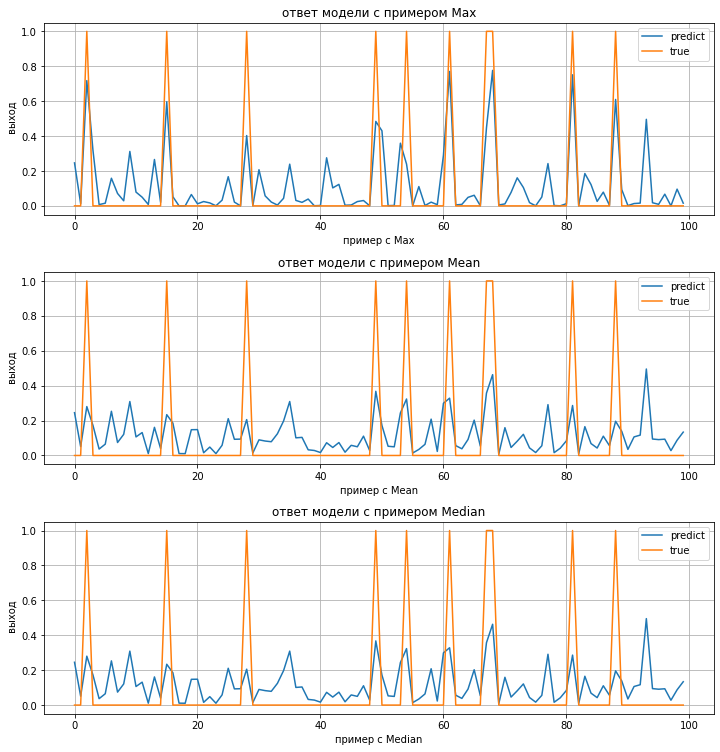

In [75]:
fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(12, 8)
ax1, ax2, ax3 = ax.flatten()

ax1.plot(preds_max[:100], label = 'predict')
ax1.plot(y_test_max.values[:100], label = 'true')
ax1.set_title('ответ модели с примером Max')
ax1.set_xlabel('пример c Max')
ax1.set_ylabel(' выход')
ax1.legend()
ax1.grid(True)

ax2.plot(preds_mean[:100], label = 'predict')
ax2.plot(y_test_mean.values[:100], label = 'true')
ax2.set_title('ответ модели c примером Mean')
ax2.set_xlabel('пример c Mean')
ax2.set_ylabel(' выход')
ax2.legend()
ax2.grid(True)

ax3.plot(preds_median[:100], label = 'predict')
ax3.plot(y_test_median.values[:100], label = 'true')
ax3.set_title('ответ модели с примером Median')
ax3.set_xlabel('пример c Median')
ax3.set_ylabel(' выход')
ax3.legend()
ax3.grid(True)

fig.subplots_adjust(bottom = 0.1, top = 1.3, wspace=1.3, hspace=0.3)


In [76]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max.values, preds_max)

In [77]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean.values, preds_mean)

In [78]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median.values, preds_median)

## Fscore Max-Mean-Median

In [79]:
n=-1
fscore_max = (2 * precision_max[:n] * recall_max[:n]) / (precision_max[:n] + recall_max[:n])

# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.367402, F-Score=0.739, Precision=0.739, Recall=0.739


In [80]:
n=-1
fscore_mean = (2 * precision_mean[:n] * recall_mean[:n]) / (precision_mean[:n] + recall_mean[:n])

# locate the index of the largest f score
ix = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

Best Threshold=0.241227, F-Score=0.663, Precision=0.579, Recall=0.776


In [81]:
n=-1
fscore_median = (2 * precision_median[:n] * recall_median[:n]) / (precision_median[:n] + recall_median[:n])

# locate the index of the largest f score
ix = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.241227, F-Score=0.663, Precision=0.579, Recall=0.776


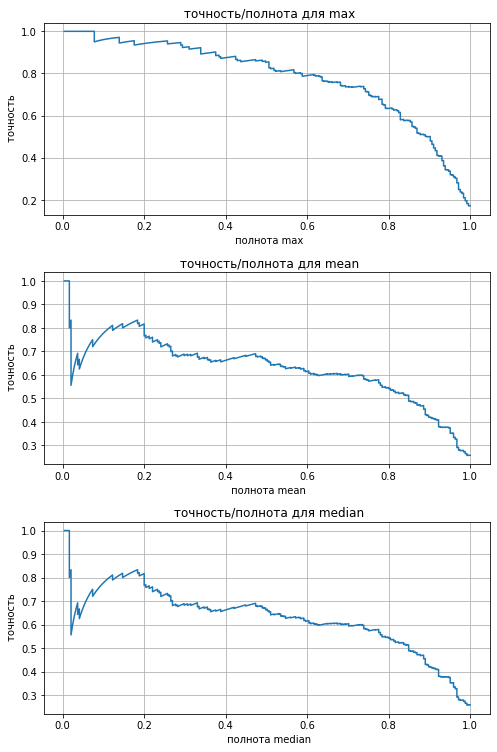

In [83]:
fig, ax = plt.subplots(nrows=3)
fig.set_size_inches(8, 8)
ax1, ax2, ax3 = ax.flatten()

ax1.plot(recall_max[:n],precision_max[:n] )
ax1.set_title(' точность/полнота для max')
ax1.set_xlabel(' полнота max')
ax1.set_ylabel(' точность')
ax1.grid(True)

ax2.plot(recall_mean[:n],precision_mean[:n] )
ax2.set_title(' точность/полнота для mean')
ax2.set_xlabel(' полнота mean')
ax2.set_ylabel(' точность')
ax2.grid(True)

ax3.plot(recall_median[:n],precision_median[:n] )
ax3.set_title(' точность/полнота для median')
ax3.set_xlabel(' полнота median')
ax3.set_ylabel(' точность')
ax3.grid(True)

fig.subplots_adjust(bottom = 0.1, top = 1.3, wspace=1.3, hspace=0.3)


In [84]:
import itertools

In [85]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Confusion matrix for Max example

Confusion matrix, without normalization
[[1192  563]
 [   8  237]]


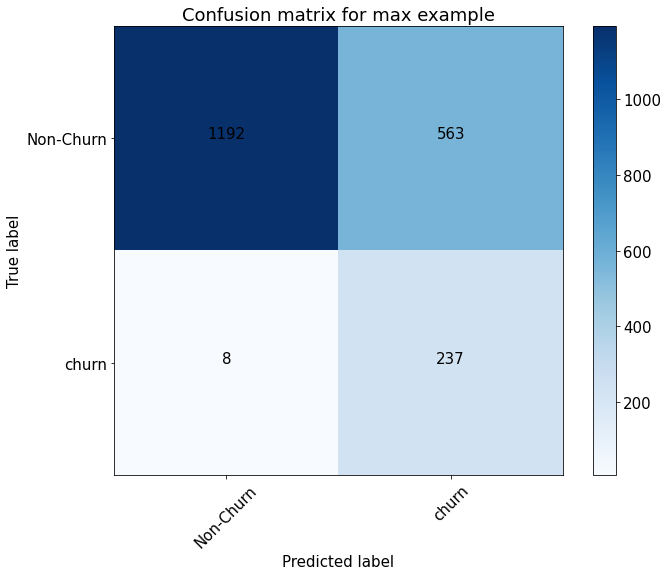

In [86]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_max, preds_max>thresholds_max[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix for max example')
plt.savefig("conf_matrix.png")
plt.show()

## Confusion matrix for Mean example

Confusion matrix, without normalization
[[1617  138]
 [  56  189]]


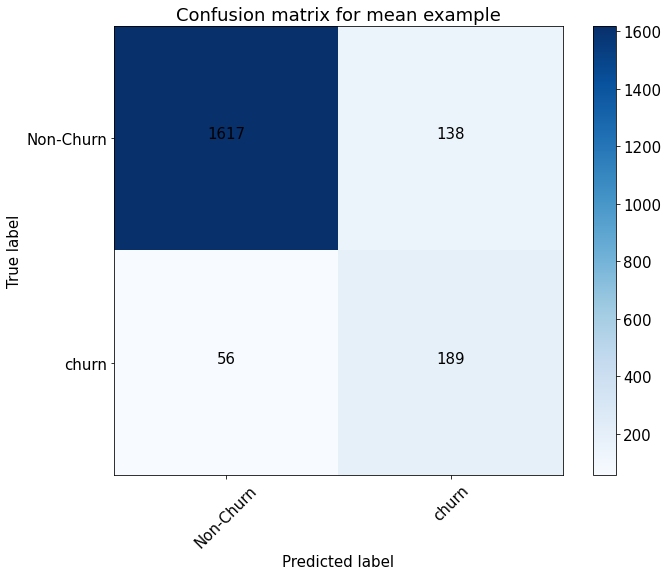

In [87]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_mean, preds_mean>thresholds_mean[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix for mean example')
plt.savefig("conf_matrix.png")
plt.show()

## Confusion matrix for Median example

Confusion matrix, without normalization
[[1617  138]
 [  56  189]]


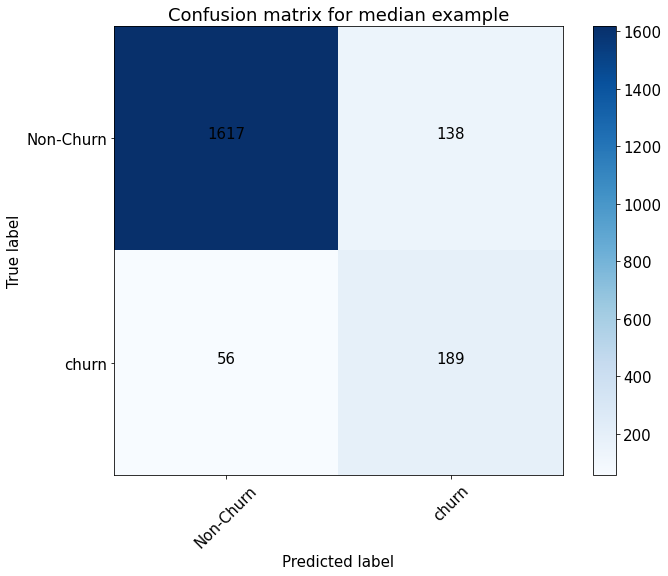

In [88]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test_median, preds_mean>thresholds_median[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix for median example')
plt.savefig("conf_matrix.png")
plt.show()

In [97]:
roc_auc_max = roc_auc_score(y_test_max, preds_max)

In [98]:
roc_auc_mean = roc_auc_score(y_test_mean, preds_mean)

In [99]:
roc_auc_median = roc_auc_score(y_test_median, preds_median)

In [100]:
#Ожидаемо, что значения mean, median совпали, ведь мы нормировали все данные которые к нам поступали. 

In [105]:
result = pd.DataFrame(index = ['roc_auc', 'threshold', 'fscore', 'precision', 'recall'], 
                      columns = ['max', 'mean', 'median'])

In [104]:
roc_auc_max, thresholds_max[ix], fscore_max[ix], precision_max[ix], recall_max[ix]

(0.94865515436944,
 0.07559151996006953,
 0.45315487571701724,
 0.2958801498127341,
 0.9673469387755103)

In [107]:
result['max'] = roc_auc_max, thresholds_max[ix], fscore_max[ix], precision_max[ix], recall_max[ix]

In [108]:
result['mean'] = roc_auc_mean, thresholds_mean[ix], fscore_mean[ix], precision_mean[ix], recall_mean[ix]

In [109]:
result['median'] = roc_auc_median, thresholds_median[ix], fscore_median[ix], precision_median[ix], recall_median[ix]

In [110]:
result.head()

,max,mean,median
roc_auc,0.948655,0.935682,0.935682
threshold,0.075592,0.241227,0.241227
fscore,0.453155,0.663176,0.663176
precision,0.295880,0.579268,0.579268
recall,0.967347,0.775510,0.775510


In [111]:
#Выводы: 
#- крайне высокие показатели по max были достигнуты как мне кажется из-за методы,
# которым мы оперировали при реализации эмбедингов. И если от нас бизнес потребует максимальный охват,
# то разумно строить модель, используя эту метрику. 
# - если мы должны добиться максимального precision при охвате выше среднего, то лучше mean(на отнормированных данных)
# и median на неотнормированных. 

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

Основная программа дз выполнена, но осталась дополнительно дз с tf-idf. Сделаем его чуть позже. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk